In [91]:
import os
import pandas as pd
import yaml
import csv

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [92]:
root_dir = r".\results\2024Apr11-215305_configs"

In [93]:
def collect_experiment_data(root_dir):
    """
    Collects experiment data and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected data and parameters.
    """
    all_data = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith("loss_record.csv"):
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the loss record CSV file
                df = pd.read_csv(file_path)

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Add parameters as new columns to the DataFrame
                df["run_id"] = run_id
                df["tau"] = tau
                df["min_samples"] = min_samples

                # Append to the list of all data
                all_data.append(df)

    # Concatenate all data into a single DataFrame
    return pd.concat(all_data, ignore_index=True)


combined_data = collect_experiment_data(root_dir)
combined_data

aggregated_df = (
    combined_data.groupby(["run_id", "tau", "min_samples"])
    .agg({"epoch": "max"})
    .reset_index()
)

aggregated_df

,run_id,tau,min_samples,epoch
0,0,0.001,10,29
1,0,0.010,10,29
2,0,0.100,10,29
3,0,1.000,10,29
4,1,0.001,10,29
...,...,...,...,...
75,18,1.000,10,29
76,19,0.001,10,29
77,19,0.010,10,29
78,19,0.100,10,29


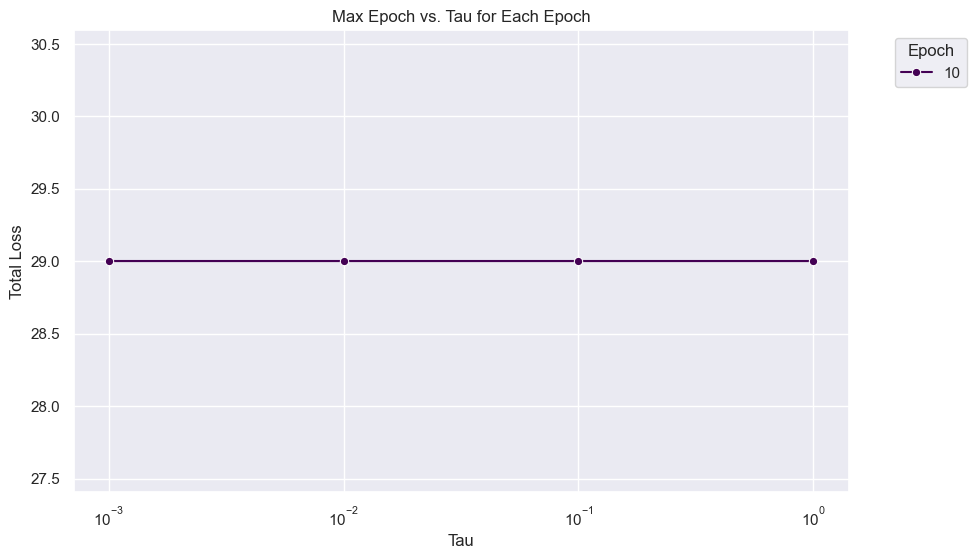

In [94]:
plt.figure(figsize=(10, 6))
# Assuming you want to plot the loss for the last epoch of each run, you can filter or aggregate the data as needed
sns.lineplot(
    data=aggregated_df,
    x="tau",
    y="epoch",
    hue="min_samples",
    palette="viridis",
    marker="o",
)
plt.xlabel("Tau")
plt.ylabel("Total Loss")
plt.xscale("log")
# plt.yscale('log')
plt.title("Max Epoch vs. Tau for Each Epoch")
plt.legend(title="Epoch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [107]:
def collect_bellman_errors(root_dir):
    """
    Collects Bellman error values and selected parameters from configuration files across multiple runs.

    Parameters:
    - root_dir: The root directory where experiment results are stored.

    Returns:
    - A pandas DataFrame containing the collected Bellman errors and parameters.
    """
    all_errors = []

    # Walk through the directory structure
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file == "bellman_error.csv":
                # Path to the current file
                file_path = os.path.join(subdir, file)
                # Read the Bellman error values from the CSV file
                with open(file_path, "r") as error_file:
                    csv_reader = csv.reader(error_file)
                    headers = next(csv_reader)  # Skip header row
                    values = next(csv_reader)  # Get the values

                # Map the values to their corresponding headers
                bellman_errors = dict(zip(headers, values))
                validation_error = float(bellman_errors['validation_error'])
                training_error = float(bellman_errors['training_error'])

                # Load the corresponding cfg.yaml file to get parameters
                cfg_path = os.path.join(subdir, "cfg.yaml")
                with open(cfg_path, "r") as cfg_file:
                    cfg_data = yaml.safe_load(cfg_file)

                # Extract needed parameters
                run_id = cfg_data.get("run_id")
                tau = cfg_data["tau"]
                min_samples = cfg_data["min_samples"]

                # Create a dictionary with the collected data
                error_data = {
                    "run_id": run_id,
                    "tau": tau,
                    "min_samples": min_samples,
                    "validation_error": validation_error,
                    "training_error": training_error
                }

                # Append to the list of all errors
                all_errors.append(error_data)

    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(all_errors)


# Example usage
bellman_errors_df = collect_bellman_errors(root_dir)
bellman_errors_df

bellman_errors_df = pd.melt(bellman_errors_df, id_vars=['run_id', 'tau', 'min_samples'], value_vars=['validation_error', 'training_error'], var_name='error_type', value_name='error_value')
bellman_errors_df

,run_id,tau,min_samples,error_type,error_value
0,0,0.001,10,validation_error,1.205256e-03
1,1,0.001,10,validation_error,1.241800e+02
2,10,0.001,10,validation_error,4.141199e+10
3,11,0.001,10,validation_error,2.933084e+00
4,12,0.001,10,validation_error,1.010941e-02
...,...,...,...,...,...
155,5,1.000,10,training_error,1.027295e-03
156,6,1.000,10,training_error,5.463429e-04
157,7,1.000,10,training_error,6.649299e-04
158,8,1.000,10,training_error,1.261306e-03


In [96]:
# # bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["tau"]!=0.01]
# bellman_errors_df_filtered = bellman_errors_df[bellman_errors_df["min_samples"] != 0]

In [97]:
# bellman_errors_df_filtered["min_samples"] = bellman_errors_df_filtered[
#     "min_samples"
# ].astype(str)

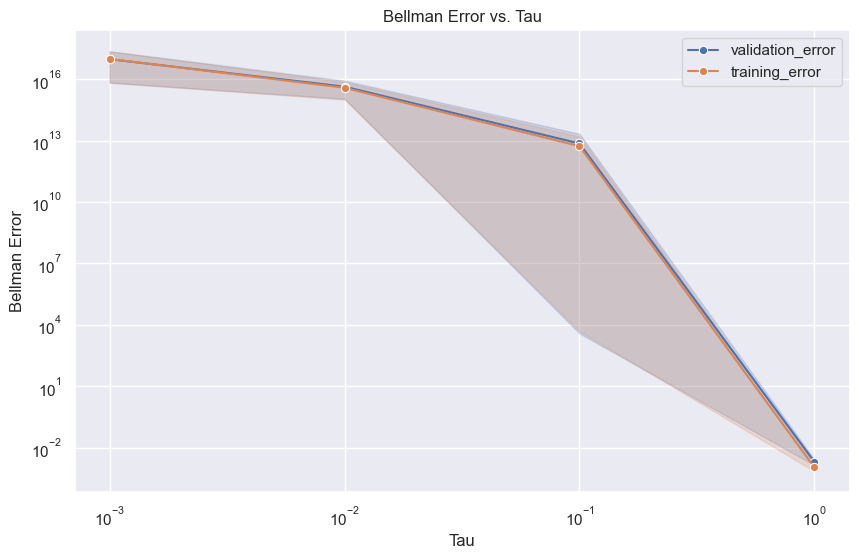

In [109]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df,
    x="tau",
    y="error_value",
    hue="error_type",
    marker="o",
    # errorbar=("pi", 100),
    errorbar="ci"
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

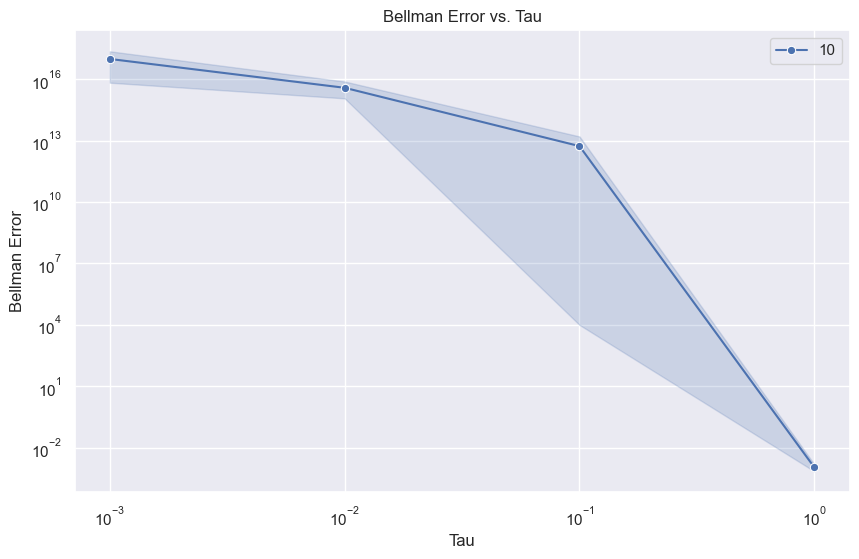

In [102]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bellman_errors_df_filtered,
    x="tau",
    y="training_error",
    hue="min_samples",
    marker="o",
    # errorbar=("pi", 100),
    errorbar="ci"
    # label="Bellman Error",
)
plt.xlabel("Tau")
plt.ylabel("Bellman Error")
plt.xscale("log")
plt.yscale("log")
plt.title("Bellman Error vs. Tau")
plt.legend()
plt.show()

In [ ]:
high_tau_df = bellman_errors_df_filtered[bellman_errors_df_filtered["tau"] == 1]
high_tau_df["bellman_error"].mean()

1.2314987458506947

In [ ]:
bellman_errors_df_filtered["bellman_error"].min()

0.0001478157500969246

In [ ]:
bellman_errors_df_filtered

,run_id,tau,min_samples,bellman_error
0,0,0.001,10,3.374364e-04
1,1,0.001,10,1.065268e-02
2,10,0.001,10,2.584820e+10
3,11,0.001,10,1.179150e-02
4,12,0.001,10,1.055772e-02
...,...,...,...,...
75,5,1.000,10,1.370789e-03
76,6,1.000,10,5.805223e-04
77,7,1.000,10,2.926977e-04
78,8,1.000,10,1.956105e-03


In [ ]:
# use mdp to generate transition distribution
# this generates another dataset of transitions

# then apply:
# ### Training
# input_size = len(states[0])  # Or another way to represent the size of your input
# output_size = len(actions)

# # Initialize the DQN
# dqn = DQN(input_size, output_size)

# loss_record = train_dqn(
#     dqn,
#     sampled_transitions_train,
#     Q_pi_random,
#     states,
#     actions,
#     gamma,
#     epsilon,
#     batch_size=batch_size,
#     max_iterations=train_max_iterations,
#     logger=logger,
# )

# bm_error = compute_bellmans_error(
#     dqn, validation_transitions=transitions_val, gamma=gamma
# )

### AND

# policy evaluation

# plot both

In [ ]:
# do policy evaluation on train datasets -> Q
# Evaluate with Q on validation set

# training DQN == value iteration
# we want to do policy evaluation with DQN (we do this by changing the loss function with bellman equation for Q pi instead of Q*)
# if we want to do early stopping, do it with Q* instead of Q pi random

In [ ]:
print(30 * 20 * 3, 30.75 / (30 * 20 * 3))
print(35 * 25 * 4, 34.7 / (35 * 25 * 4))
print(35 * 27 * 5, 32.2 / (35 * 27 * 5))
print(41 * 25 * 8, 40.49 / (41 * 25 * 8))
print(43 * 29 * 7.5, 60 / (43 * 29 * 7.5))
print(44 * 34 * 5, 46 / (44 * 34 * 5))

1800 0.017083333333333332
3500 0.009914285714285716
4725 0.006814814814814815
8200 0.004937804878048781
9352.5 0.006415396952686447
7480 0.006149732620320855
